In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [6]:
# Đọc dữ liệu
df = pd.read_csv('AIDS_Classification_50000.csv')
df


,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,1073,1,37,79.46339,0,1,0,100,0,1,...,1,2,0,1,0,322,469,882,754,1
1,324,0,33,73.02314,0,1,0,90,0,1,...,1,3,1,1,1,168,575,1035,1525,1
2,495,1,43,69.47793,0,1,0,100,0,1,...,1,1,0,0,0,377,333,1147,1088,1
3,1201,3,42,89.15934,0,1,0,100,1,1,...,1,3,0,0,0,238,324,775,1019,1
4,934,0,37,137.46581,0,1,0,100,0,0,...,0,3,0,0,1,500,443,1601,849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,953,3,46,61.28204,0,0,0,90,0,1,...,1,3,0,1,1,234,402,481,1014,0
49996,1036,0,42,73.36768,0,1,0,100,0,1,...,1,3,0,0,1,369,575,514,657,0
49997,1157,0,40,78.75824,0,1,0,100,0,1,...,1,1,0,1,0,308,663,1581,863,0
49998,596,0,31,52.20371,0,0,0,100,0,1,...,1,1,0,1,1,349,440,470,865,1


In [7]:
target = 'infected'
cont_cols = ['time', 'age', 'wtkg', 'preanti',
             'cd40', 'cd420', 'cd80', 'cd820']
dis_cols = list(set(df.columns) - set([*cont_cols, target]))

len(cont_cols), len(dis_cols)

(8, 14)

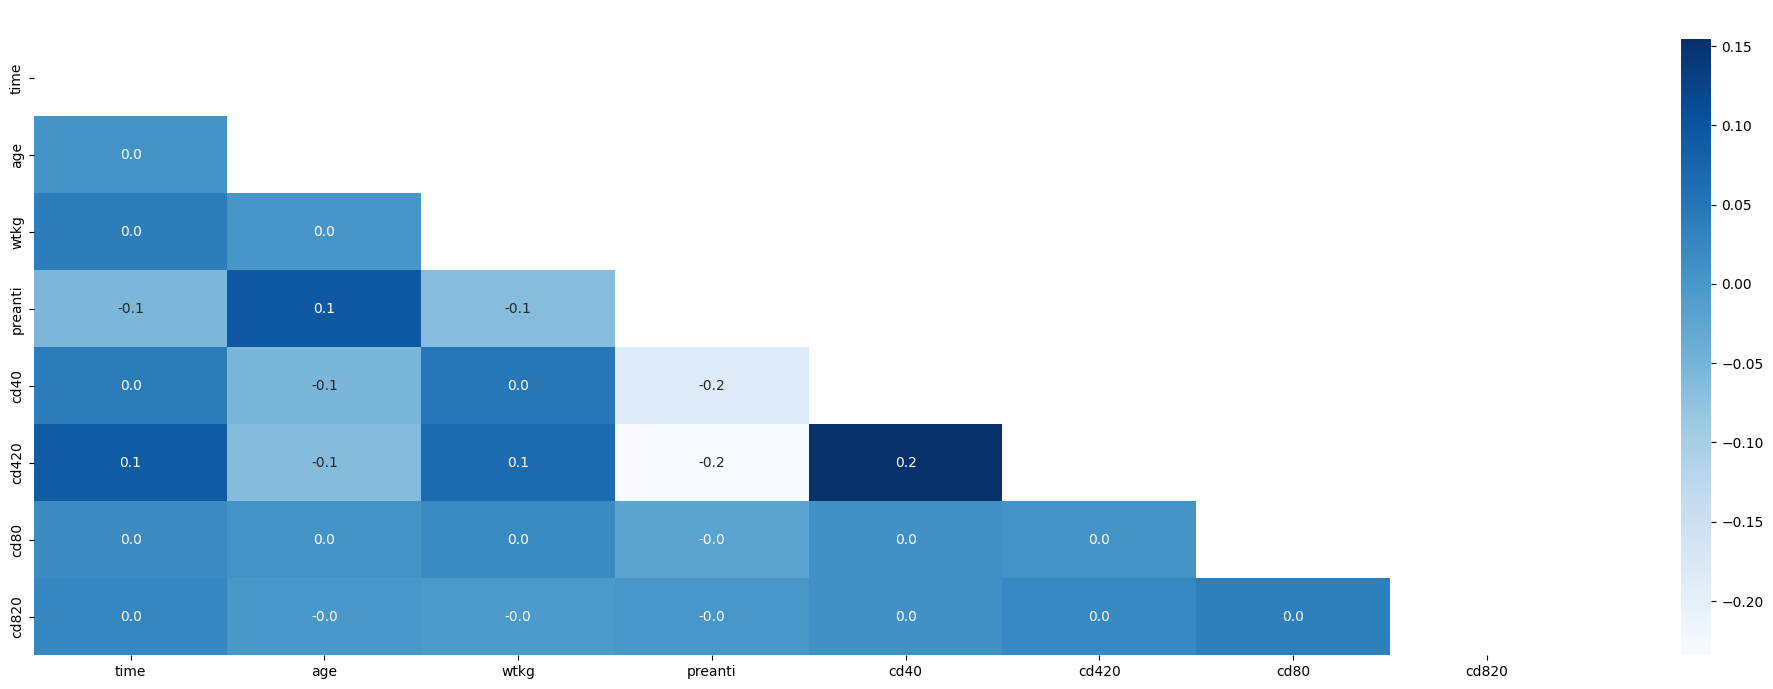

In [8]:
fig = plt.figure(figsize=(25, 8))

gs = fig.add_gridspec(1, 1)

gs.update(wspace=0.3, hspace=0.15)

ax = fig.add_subplot(gs[0, 0])

ax.set_title("Correlation Matrix", fontsize=20,
             fontweight='bold', fontfamily='serif', color="#fff")

sns.heatmap(df[cont_cols].corr().transpose(), mask=np.triu(np.ones_like(
    df[cont_cols].corr().transpose())), fmt=".1f", annot=True, cmap='Blues')

plt.show()

In [9]:
X = df.iloc[:, :-1] #gán dữ liệu từ cột 0 đến n-1
Y = df.iloc[:, -1] #dùng cột 'infected' để làm nhãn

# thực hiện chia dữ liệu thành tập x và y
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=3, train_size=0.7)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((35000, 22), (35000,), (15000, 22), (15000,))

In [10]:
#xử lý mất cân bằng dữ liệu
smote = SMOTE(random_state=14)

x_train, y_train = smote.fit_resample(x_train, y_train)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((48260, 22), (48260,), (15000, 22), (15000,))

In [11]:
# chuẩn hoá dữ liệu
x_train = MinMaxScaler().fit_transform(x_train)
x_test = MinMaxScaler().fit_transform(x_test)

In [12]:
def objective(trial):
    params = {
        # Số vòng lặp tối đa
        'iterations': trial.suggest_int('iterations', 100, 1000), 
        # Tốc độ học
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5), 
        # Độ sâu của cây quyết định
        'depth': trial.suggest_int('depth', 1, 12),
        # Regularization L2 trên các lá
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        # Số lượng ngưỡng phân chia liên tục
        'border_count': trial.suggest_int('border_count', 1, 255),
        # Số luồng được sử dụng (để tối ưu hóa)
        'thread_count': -1,
        # Hàm mất mát (sử dụng 'MultiClass' cho bài toán phân loại đa lớp)
        'loss_function': 'MultiClass',
        # Tiêu chí đánh giá (sử dụng 'Accuracy' cho bài toán phân loại)
        'eval_metric': 'Accuracy',
        # Hiển thị quá trình huấn luyện
        'verbose': False
    }

    model = CatBoostClassifier(**params)

    model.fit(x_train, y_train, eval_set=(x_test, y_test),
              verbose=False, early_stopping_rounds=20)

    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy


study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2024-07-25 11:54:33,599] A new study created in memory with name: no-name-4536645c-0e10-4e77-801e-efebbab2f955


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:54:41,860] Trial 0 finished with value: 0.6668 and parameters: {'iterations': 770, 'learning_rate': 0.07649027560234468, 'depth': 12, 'l2_leaf_reg': 0.011284773592340477, 'border_count': 76}. Best is trial 0 with value: 0.6668.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:54:42,660] Trial 1 finished with value: 0.6681333333333334 and parameters: {'iterations': 896, 'learning_rate': 0.3831954226476081, 'depth': 8, 'l2_leaf_reg': 4.170791625329502, 'border_count': 24}. Best is trial 1 with value: 0.6681333333333334.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:54:43,335] Trial 2 finished with value: 0.6642 and parameters: {'iterations': 955, 'learning_rate': 0.18641033948311214, 'depth': 8, 'l2_leaf_reg': 0.05080451538715558, 'border_count': 9}. Best is trial 1 with value: 0.6681333333333334.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:54:47,367] Trial 3 finished with value: 0.6555333333333333 and parameters: {'iterations': 560, 'learning_rate': 0.31003978384113456, 'depth': 12, 'l2_leaf_reg': 0.015060445063188413, 'border_count': 32}. Best is trial 1 with value: 0.6681333333333334.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:54:47,993] Trial 4 finished with value: 0.6674666666666667 and parameters: {'iterations': 758, 'learning_rate': 0.3447741919327485, 'depth': 8, 'l2_leaf_reg': 0.09994074114683349, 'border_count': 80}. Best is trial 1 with value: 0.6681333333333334.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:54:56,231] Trial 5 finished with value: 0.6671333333333334 and parameters: {'iterations': 943, 'learning_rate': 0.17852198347794335, 'depth': 12, 'l2_leaf_reg': 0.8942082328023281, 'border_count': 209}. Best is trial 1 with value: 0.6681333333333334.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:54:57,367] Trial 6 finished with value: 0.6671333333333334 and parameters: {'iterations': 297, 'learning_rate': 0.13453599940730165, 'depth': 8, 'l2_leaf_reg': 1.0793783593360886, 'border_count': 72}. Best is trial 1 with value: 0.6681333333333334.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:54:57,591] Trial 7 finished with value: 0.5992 and parameters: {'iterations': 780, 'learning_rate': 0.015837861719299427, 'depth': 1, 'l2_leaf_reg': 0.00735153221713899, 'border_count': 170}. Best is trial 1 with value: 0.6681333333333334.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:02,313] Trial 8 finished with value: 0.6668 and parameters: {'iterations': 336, 'learning_rate': 0.09441066595566174, 'depth': 11, 'l2_leaf_reg': 0.007136818631674083, 'border_count': 90}. Best is trial 1 with value: 0.6681333333333334.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:03,031] Trial 9 finished with value: 0.6668666666666667 and parameters: {'iterations': 683, 'learning_rate': 0.20301816888907356, 'depth': 2, 'l2_leaf_reg': 0.18127127555029307, 'border_count': 59}. Best is trial 1 with value: 0.6681333333333334.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:05,137] Trial 10 finished with value: 0.6653333333333333 and parameters: {'iterations': 503, 'learning_rate': 0.02964391199021399, 'depth': 4, 'l2_leaf_reg': 7.146743299986853, 'border_count': 134}. Best is trial 1 with value: 0.6681333333333334.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:06,046] Trial 11 finished with value: 0.6698666666666667 and parameters: {'iterations': 999, 'learning_rate': 0.30398098151027464, 'depth': 6, 'l2_leaf_reg': 0.20043340743872215, 'border_count': 121}. Best is trial 11 with value: 0.6698666666666667.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:06,620] Trial 12 finished with value: 0.6713333333333333 and parameters: {'iterations': 999, 'learning_rate': 0.4551199839439628, 'depth': 5, 'l2_leaf_reg': 9.573020829712556, 'border_count': 251}. Best is trial 12 with value: 0.6713333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:06,948] Trial 13 finished with value: 0.6434666666666666 and parameters: {'iterations': 984, 'learning_rate': 0.03912939088503285, 'depth': 5, 'l2_leaf_reg': 0.0012243328097163446, 'border_count': 220}. Best is trial 12 with value: 0.6713333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:07,536] Trial 14 finished with value: 0.6698666666666667 and parameters: {'iterations': 152, 'learning_rate': 0.3960582786108976, 'depth': 5, 'l2_leaf_reg': 0.66610468540292, 'border_count': 244}. Best is trial 12 with value: 0.6713333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:09,204] Trial 15 finished with value: 0.6668666666666667 and parameters: {'iterations': 837, 'learning_rate': 0.04751469740045706, 'depth': 3, 'l2_leaf_reg': 9.889197456688187, 'border_count': 135}. Best is trial 12 with value: 0.6713333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:09,661] Trial 16 finished with value: 0.6687333333333333 and parameters: {'iterations': 637, 'learning_rate': 0.25174714338562676, 'depth': 5, 'l2_leaf_reg': 2.05056416581674, 'border_count': 171}. Best is trial 12 with value: 0.6713333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:10,119] Trial 17 finished with value: 0.6684 and parameters: {'iterations': 869, 'learning_rate': 0.4607084698555405, 'depth': 6, 'l2_leaf_reg': 0.2686175330082505, 'border_count': 174}. Best is trial 12 with value: 0.6713333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:11,335] Trial 18 finished with value: 0.6588666666666667 and parameters: {'iterations': 451, 'learning_rate': 0.49954605599941965, 'depth': 10, 'l2_leaf_reg': 0.03823441189719035, 'border_count': 113}. Best is trial 12 with value: 0.6713333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:13,218] Trial 19 finished with value: 0.6714 and parameters: {'iterations': 653, 'learning_rate': 0.11587874124638371, 'depth': 7, 'l2_leaf_reg': 0.001569619483057324, 'border_count': 205}. Best is trial 19 with value: 0.6714.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:13,607] Trial 20 finished with value: 0.663 and parameters: {'iterations': 634, 'learning_rate': 0.12311935181051935, 'depth': 7, 'l2_leaf_reg': 0.001480754478622089, 'border_count': 237}. Best is trial 19 with value: 0.6714.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:14,345] Trial 21 finished with value: 0.669 and parameters: {'iterations': 972, 'learning_rate': 0.12875376266778468, 'depth': 6, 'l2_leaf_reg': 0.2226636400143095, 'border_count': 199}. Best is trial 19 with value: 0.6714.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:15,231] Trial 22 finished with value: 0.6691333333333334 and parameters: {'iterations': 839, 'learning_rate': 0.26189344046068125, 'depth': 4, 'l2_leaf_reg': 0.0033524330752299062, 'border_count': 249}. Best is trial 19 with value: 0.6714.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:15,676] Trial 23 finished with value: 0.6592666666666667 and parameters: {'iterations': 397, 'learning_rate': 0.056754989614731355, 'depth': 7, 'l2_leaf_reg': 0.03444856890286433, 'border_count': 194}. Best is trial 19 with value: 0.6714.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:17,633] Trial 24 finished with value: 0.6688 and parameters: {'iterations': 126, 'learning_rate': 0.22946187241673074, 'depth': 9, 'l2_leaf_reg': 2.0849155668154298, 'border_count': 149}. Best is trial 19 with value: 0.6714.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:18,529] Trial 25 finished with value: 0.6682666666666667 and parameters: {'iterations': 706, 'learning_rate': 0.09334532690974491, 'depth': 6, 'l2_leaf_reg': 0.400833035783911, 'border_count': 107}. Best is trial 19 with value: 0.6714.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:18,904] Trial 26 finished with value: 0.6316666666666667 and parameters: {'iterations': 581, 'learning_rate': 0.02527282358359608, 'depth': 3, 'l2_leaf_reg': 0.07573185089557764, 'border_count': 225}. Best is trial 19 with value: 0.6714.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:19,733] Trial 27 finished with value: 0.6686666666666666 and parameters: {'iterations': 892, 'learning_rate': 0.16079818337850382, 'depth': 4, 'l2_leaf_reg': 0.002624342119414677, 'border_count': 254}. Best is trial 19 with value: 0.6714.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:22,573] Trial 28 finished with value: 0.669 and parameters: {'iterations': 801, 'learning_rate': 0.31151663579061695, 'depth': 9, 'l2_leaf_reg': 2.88857238271169, 'border_count': 153}. Best is trial 19 with value: 0.6714.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:23,645] Trial 29 finished with value: 0.6676666666666666 and parameters: {'iterations': 261, 'learning_rate': 0.09257040414429023, 'depth': 7, 'l2_leaf_reg': 0.01987770848157179, 'border_count': 189}. Best is trial 19 with value: 0.6714.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:23,956] Trial 30 finished with value: 0.6353333333333333 and parameters: {'iterations': 749, 'learning_rate': 0.01217514384265467, 'depth': 5, 'l2_leaf_reg': 0.004161265198605533, 'border_count': 114}. Best is trial 19 with value: 0.6714.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:24,554] Trial 31 finished with value: 0.6685333333333333 and parameters: {'iterations': 124, 'learning_rate': 0.3931839043028776, 'depth': 5, 'l2_leaf_reg': 0.5708183094267764, 'border_count': 232}. Best is trial 19 with value: 0.6714.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:24,923] Trial 32 finished with value: 0.6737333333333333 and parameters: {'iterations': 998, 'learning_rate': 0.3962067787041822, 'depth': 6, 'l2_leaf_reg': 0.13834365669422286, 'border_count': 242}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:25,740] Trial 33 finished with value: 0.6696666666666666 and parameters: {'iterations': 910, 'learning_rate': 0.2828244918488092, 'depth': 6, 'l2_leaf_reg': 0.10388422287990678, 'border_count': 209}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:26,563] Trial 34 finished with value: 0.6663333333333333 and parameters: {'iterations': 995, 'learning_rate': 0.469835511998827, 'depth': 7, 'l2_leaf_reg': 0.14250914133805834, 'border_count': 255}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:27,472] Trial 35 finished with value: 0.6654 and parameters: {'iterations': 927, 'learning_rate': 0.35339303078276924, 'depth': 9, 'l2_leaf_reg': 0.027216922317928886, 'border_count': 218}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:28,496] Trial 36 finished with value: 0.6676666666666666 and parameters: {'iterations': 929, 'learning_rate': 0.21658242523751456, 'depth': 8, 'l2_leaf_reg': 0.056446466924263035, 'border_count': 235}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:29,390] Trial 37 finished with value: 0.67 and parameters: {'iterations': 999, 'learning_rate': 0.1614681458904868, 'depth': 3, 'l2_leaf_reg': 1.380514277571712, 'border_count': 184}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:29,832] Trial 38 finished with value: 0.6667333333333333 and parameters: {'iterations': 860, 'learning_rate': 0.16489762143530348, 'depth': 3, 'l2_leaf_reg': 4.775725456074781, 'border_count': 204}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:30,871] Trial 39 finished with value: 0.6555333333333333 and parameters: {'iterations': 824, 'learning_rate': 0.07604195357914356, 'depth': 1, 'l2_leaf_reg': 1.144936972070351, 'border_count': 185}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:31,710] Trial 40 finished with value: 0.6694 and parameters: {'iterations': 734, 'learning_rate': 0.14293189561612182, 'depth': 2, 'l2_leaf_reg': 1.4608138023092272, 'border_count': 213}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:32,133] Trial 41 finished with value: 0.6691333333333334 and parameters: {'iterations': 946, 'learning_rate': 0.3345292656278561, 'depth': 4, 'l2_leaf_reg': 0.35954161021231007, 'border_count': 158}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:32,404] Trial 42 finished with value: 0.6654 and parameters: {'iterations': 999, 'learning_rate': 0.10978097354283856, 'depth': 6, 'l2_leaf_reg': 5.926462137031586, 'border_count': 51}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:32,854] Trial 43 finished with value: 0.6638 and parameters: {'iterations': 897, 'learning_rate': 0.20933827232776805, 'depth': 2, 'l2_leaf_reg': 3.5653305117852203, 'border_count': 94}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:33,462] Trial 44 finished with value: 0.6629333333333334 and parameters: {'iterations': 944, 'learning_rate': 0.4032782483152637, 'depth': 8, 'l2_leaf_reg': 0.011271257740320938, 'border_count': 226}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:34,765] Trial 45 finished with value: 0.6668 and parameters: {'iterations': 966, 'learning_rate': 0.1823101915894768, 'depth': 7, 'l2_leaf_reg': 0.1228382296547666, 'border_count': 242}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:35,147] Trial 46 finished with value: 0.6674666666666667 and parameters: {'iterations': 880, 'learning_rate': 0.289222359509201, 'depth': 5, 'l2_leaf_reg': 0.736183744410651, 'border_count': 183}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:36,061] Trial 47 finished with value: 0.6673333333333333 and parameters: {'iterations': 498, 'learning_rate': 0.0598100013709401, 'depth': 4, 'l2_leaf_reg': 0.3806692212144221, 'border_count': 124}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:36,719] Trial 48 finished with value: 0.6725333333333333 and parameters: {'iterations': 808, 'learning_rate': 0.24539678606340096, 'depth': 6, 'l2_leaf_reg': 0.05908233014330938, 'border_count': 146}. Best is trial 32 with value: 0.6737333333333333.


C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\HUUHUY\AppData\Local\Temp\ipykernel_14804\2948930189.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),


[I 2024-07-25 11:55:37,260] Trial 49 finished with value: 0.6684666666666667 and parameters: {'iterations': 828, 'learning_rate': 0.24423778625245735, 'depth': 3, 'l2_leaf_reg': 9.957668622574236, 'border_count': 139}. Best is trial 32 with value: 0.6737333333333333.


In [13]:
model = CatBoostClassifier(
    verbose=0,
    random_state=3,
    **study.best_params
)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [14]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75     10493
           1       0.42      0.43      0.42      4507

    accuracy                           0.65     15000
   macro avg       0.58      0.59      0.59     15000
weighted avg       0.65      0.65      0.65     15000



<Axes: >

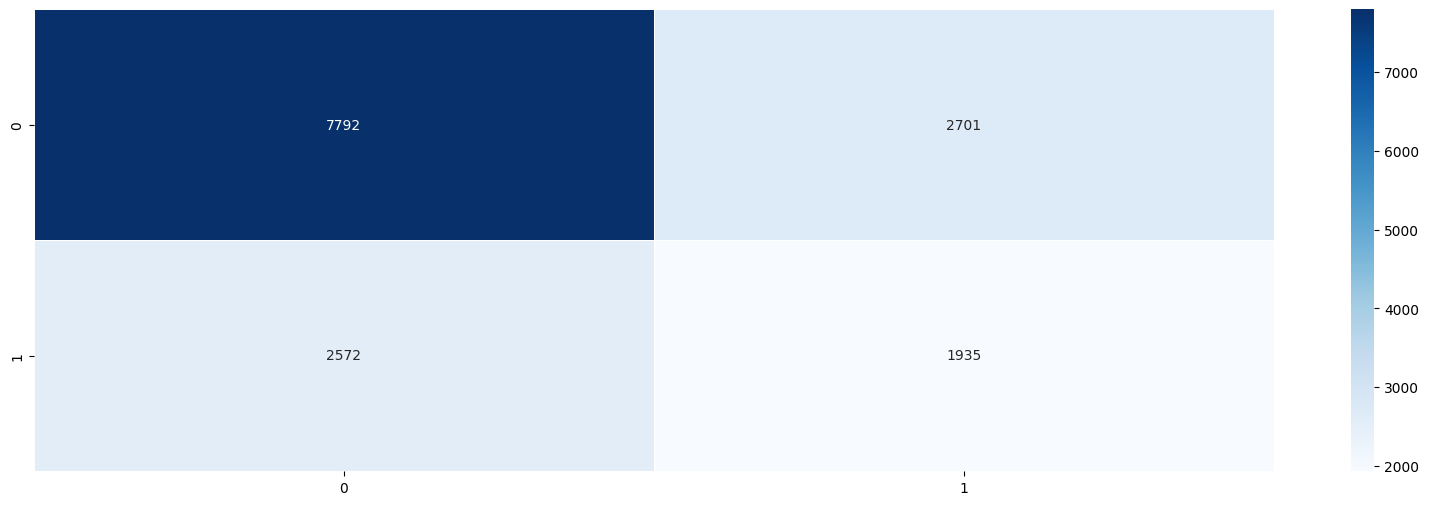

In [15]:
plt.subplots(figsize=(20, 6))

sns.heatmap(confusion_matrix(y_pred, y_test), annot=True,
            fmt="d", cmap="Blues", linewidths=.5)